In [ ]:
#pip install opencv-python
#pip install tensorflow
#pip install tensorflow_hub

In [6]:
import cv2
import os
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import json

#모델로드
model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = model.signatures["serving_default"]

In [10]:
def dancer_x_y(movenet, img):
    KEYPOINT_REVERSE = {
        0: "nose",
        1: "left_eye",
        2: "right_eye",
        3: "left_ear",
        4: "right_ear",
        5: "left_shoulder",
        6: "right_shoulder",
        7: "left_elbow",
        8: "right_elbow",
        9: "left_wrist",
        10: "right_wrist",
        11: "left_hip",
        12: "right_hip",
        13: "left_knee",
        14: "right_knee",
        15: "left_ankle",
        16: "right_ankle"
    }
    
    result = [{"keypoints": []}]
    
    tmp = []
    input_size = 192
    
    y, x, _ = img.shape
    image = tf.expand_dims(img, axis=0)
    image = tf.image.resize_with_pad(image, input_size, input_size)
    image = tf.cast(image, dtype=tf.int32)
    
    outputs = movenet(image)

    # Output is a [1, 1, 17, 3] tensor.
    keypoints = outputs["output_0"]
    cnt = 0
    total_score = 0
    for keypoint in keypoints[0, 0, :, :]:
        keypoint = keypoint.numpy().astype(float)
        total_score+=keypoint[2]

        yc = keypoint[0] * y
        xc = keypoint[1] * x

        data = {"y": yc,
                "x": xc,
                "score": keypoint[2],
                "name": KEYPOINT_REVERSE[cnt]}

        tmp.append(data)
        cnt += 1
    result[0]["keypoints"] = tmp
    result[0]["score"] = total_score / 17

    return result

In [11]:
def video_to_xy(filepath, folderpath):
    '''
    filepath : 비디오의 경로 : './exo-lmr_shorts_720.mp4'
    folderpath : json파일을 저장할 폴더의 경로 : './exo-lmr'
    return : frme0.jpg, frame1.jpg, frame2.jpg, ..., 
    '''
    # #모델로드
    # model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    # movenet = model.signatures["serving_default"]
    
    #비디오 불러오기
    video = cv2.VideoCapture(filepath)

    if not video.isOpened():
        print("Could not Open :", filepath)
        exit(0)
    else:
        #불러온 비디오 파일의 정보 출력
        length = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = video.get(cv2.CAP_PROP_FPS)

        print("length :", length)
        print("width :", width)
        print("height :", height)
        print("fps :", fps)
        
        #프레임을 저장할 디렉토리를 생성
        try:
            if not os.path.exists(folderpath):
                os.makedirs(folderpath)
        except OSError:
            print ('Error: Creating directory. ' +  folderpath)
            
        count = 0
        if fps<30:
            frame_interval = 1
        else:
            frame_interval = int(fps / 30)
        
        while(video.isOpened()):
            ret, image = video.read()
            if not ret:
                print('완료')
                break
            
            if(int(video.get(1)) % frame_interval == 0): #앞서 불러온 fps 값을 사용하여 1초마다 추출
                print('Saved coordinate :', str(int(video.get(1))))
                
                with open(folderpath + "/frame%d.json" % count, 'w') as file:
                    json.dump(dancer_x_y(movenet, image), file, indent=4)
                    
                count+=1
                if count==10:
                    break

In [ ]:
filepath = './spicy_karina.mp4'
folderpath = './karina'

video_to_xy(filepath,folderpath)

In [18]:
img_path = './karina/frame0.jpg'
json_path = './karina/frame0.json'

In [21]:
with open(json_path, 'r') as file:
    data = json.load(file)

x=[]
y=[]
name=[]
for i in range(17):
    x.append(data[0]['keypoints'][i]['x'])
    y.append(data[0]['keypoints'][i]['y'])
    name.append(data[0]['keypoints'][i]['name'])

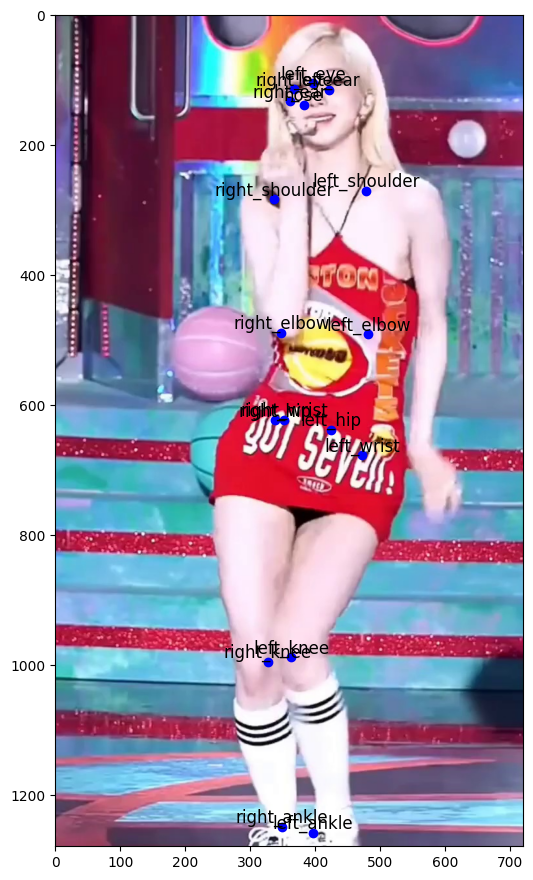

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_image_on_graph(image_path):
    # 이미지 로드
    img = mpimg.imread(image_path)

    # 그래프 생성
    fig, ax = plt.subplots(figsize=(19.2, 10.8))

    # 이미지를 그래프에 나타내기
    ax.imshow(img)
    for i in range(17):
        ax.scatter(x[i], y[i], color='blue', marker='o')
        ax.text(x[i], y[i], name[i], fontsize=12, ha='center', va='bottom')


    # 그래프에 이미지 출력
    plt.show()

# 이미지를 그래프 위에 나타내기
display_image_on_graph(img_path)

In [66]:
yoga = './yoga.jpg'
yoga = tf.io.read_file(yoga)
yoga = tf.image.decode_jpeg(yoga)
json_yoga = dancer_x_y(movenet, yoga)


x=[]
y=[]
for i in range(17):
    x.append(json_yoga[0]['keypoints'][i]['x'])
    y.append(json_yoga[0]['keypoints'][i]['y'])

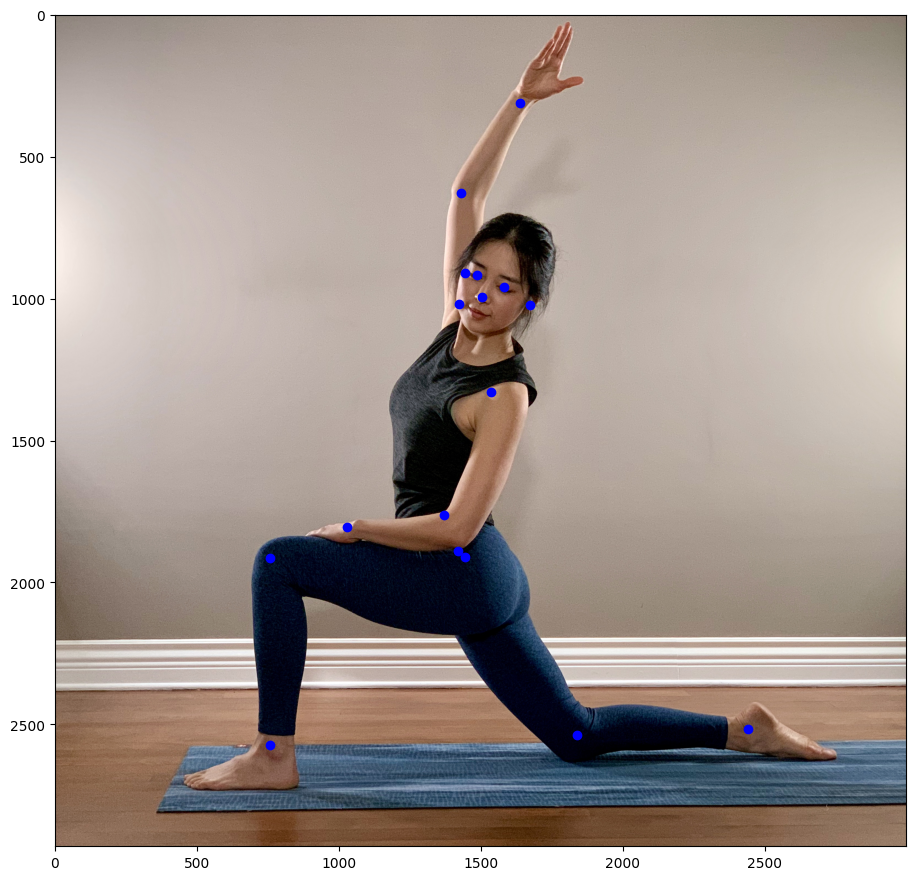

In [71]:
# 이미지를 그래프 위에 나타내기
display_image_on_graph('./yoga.jpg')